## Neural Networks
### Hand-in: Solve MNIST classification with basic tensorflow or pytorch

The goal of this exercise is to learn one of the current state-of-the-art frameworks (tensorflow and pytorch) for using neural network architectures and training.
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb
https://colab.research.google.com/github/omarsar/pytorch_notebooks/blob/master/pytorch_quick_start.ipynb

We will start off with MNIST from the basic exercise for you to reproduce the results here. Important then is to carefully go through the API and tutorial of your framework of choice and put together an MLP that can classify MNIST.

For the hand-in, go through the following tasks and answer the following questions.

Tasks:
1. Go through the API to understand what documentation and details you can find
2. Learn how to set up and use a data loader. **See Step 1**
3. Figure out and reimplement how to build a basic MLP model. **See Step 3**
4. ?? Understand and test how to set up the prerequisites of a model: data(loader), task & metrics. **See Step 3**
5. Understand and test what the respective loss function and optimisers are. **See Step 4**
6. Plot some training progress (e.g. plot the loss) **See Step 5**
7. Have a brief (!) experiment with different settings for the hyperparameters: batch_size, learning_rate, hidden_layer_sizes. **See Step 6**

Questions:
1. What is the best accuracy that you found?
* **The best accuracy is 0.9734**

2. What are good values of batch_size, learning_rate, hidden_layer_sizes - is this the same compared to the basic (sklearn) training?
* **batch size (32) same as in the basic model:** Smaller batch sizes can be computationally more expensive, but they can lead to more frequent weight updates, which may help the model converge faster. Larger batch sizes can be more efficient in terms of computation but might lead to less frequent updates and potentially slower convergence. In practice, batch sizes in the range of 32 to 128 are commonly used.
* **learning Rate (0.1) versus a smaller learning rate in the basic model (0.01):** A larger learning rate allows the model to update weights more aggressively, potentially leading to faster convergence. In comparison, a smaller learning rate such as for the basic model, might be more stable but could result in slower convergence.
* **Hidden Layer Sizes (128, 64, 28):** The model has three hidden layers with 128, 64 and 32 neurons. This increase in capacity allows the model to capture more complex relationships in the data and potentially learn more complex patterns, leading to better performance.
* **epochs (50) in combination with early stopping (True) , same as in the basic model:** Similar to the basic model the epoch number was choosen quite large while including early stopping to prevent overfitting. Already at the 10th training iteration, training was stopped.

3. What optimiser options do you have, and which one did you choose (and why)?
* **Similar to the basic mode, two optimisers were tested:**
* **Stochastic gradient Descent did not show strong over- nor underfitting. Also, the curves for validation (and learning) loss appeared to be more smooth**
* **Adam showed strong and increasing overfitting with epochs but better accuracy**
* **Overall, as in the basic model from Session 4 itt was found that SGD yields better results ceteris paribus.**

4. What did you observe in the results for good and bad hyperparameters in comparison to the basic (sklearn) training?

4.1 **Good Hyperparameters**
* **Overall Performance:** The best model (0.9734) reached a slighly higher test accuracy than the finetuned basic model (0.9701).
* **Better Generalization:** It generalizes well to unseen data which can be seen by the good performance on the test set. The model's accuracy on new data is close to the accuracy on the training data: The Test Accuracy is 0.9734 and very close to the training accuracy 0.9969. The accuracies of the basic model differ slightly more from each other.
* **For both models:** Both favored a more complex hidden layer structure. Performance increased with more and larger hidden layers. Also, larger epochs with early stopping worked well in both cases.

4.2. **Bad Hyperparamters**
* **Slow Convergence:** Bad hyperparameters lead to slow convergence during training. The training loss decreases more slowly.
* **Fluctuating learning curves:** Similarly to the basic models, the training curve fluctuates a lot for bad hyperparameterers and overvitting is often visible (large gap between training and validation learning curves).

In [2]:
from IPython.display import display
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn import model_selection
from sklearn import metrics
from sklearn import neural_network
import seaborn as sns

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import torch
import torchvision

# NEW LIbarrays
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

from keras.callbacks import EarlyStopping

TensorFlow version: 2.12.0


#### Step1: Load MNIST directly from tensorflow or pytorch
Make sure to use training and test (and potentially validation) data properly!

In [3]:
batch_size = 32

(x_trainset, y_trainset), (x_testset, y_testset) = tf.keras.datasets.mnist.load_data()
# (x_trainset, y_trainset), (x_testset, y_testset) = tf.keras.datasets.fashion_mnist.load_data()
x_trainset, x_testset = x_trainset[..., np.newaxis]/255.0, x_testset[..., np.newaxis]/255.0   # Rescale the images from [0,255] to the [0.0,1.0] range.

# Pytorch:
#trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True)
#trainset = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True)
#testset = torchvision.datasets.MNIST(root='../data', train=False, download=True)
#testset = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True)
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
#testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

#### Step 2: Preprocessing

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


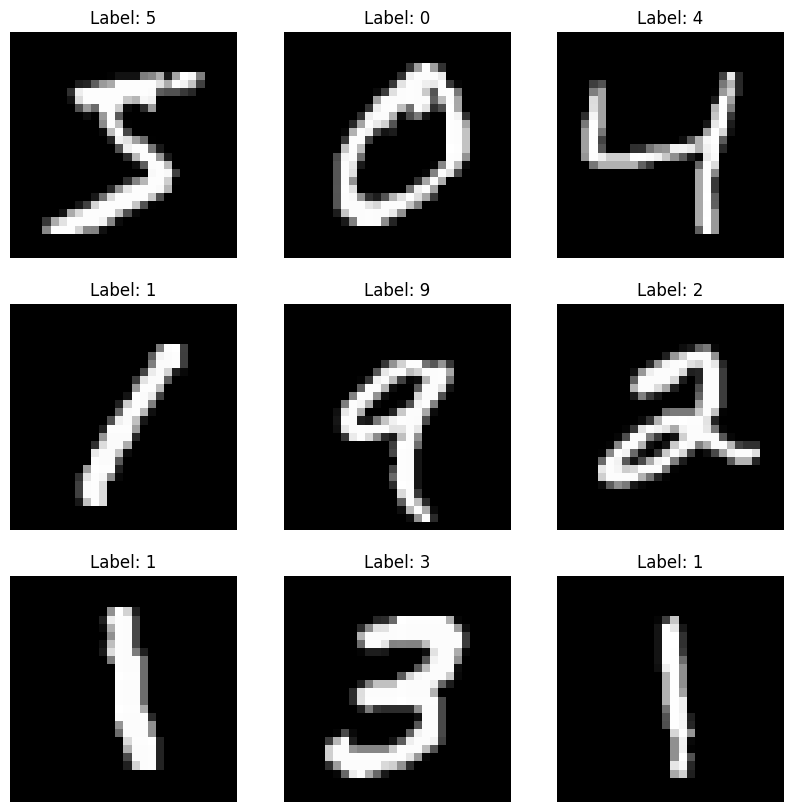

In [4]:
# load the data: see above

# pack it in tensors
print(type(x_trainset), type(y_trainset), type(x_testset), type(y_testset)) # the data has type numpy array

x_trainset = tf.convert_to_tensor(x_trainset,  dtype=tf.float32) # Convert numpy arrays to TensorFlow tensors
y_trainset = tf.convert_to_tensor(y_trainset, dtype=tf.int64)

x_testset = tf.convert_to_tensor(x_testset, dtype=tf.float32)
y_testset = tf.convert_to_tensor(y_testset, dtype=tf.int64)

print(type(x_trainset), type(y_trainset), type(x_testset), type(y_testset))

# Visualize the first 9 images and their corresponding labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_trainset[i].numpy().squeeze(), cmap='gray')
    plt.title(f"Label: {y_trainset[i].numpy()}")
    plt.axis('off')
plt.show()

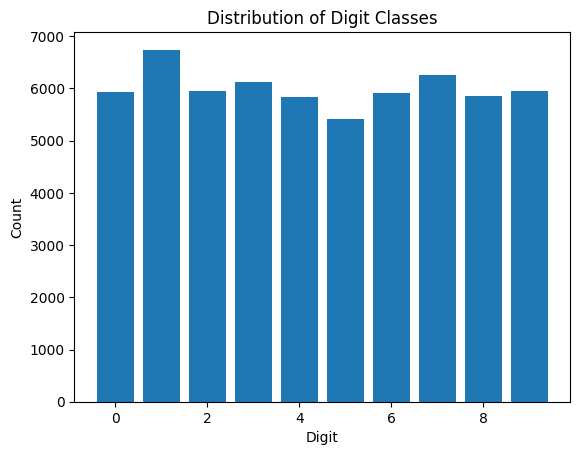

In [5]:
# Display calss distribution
# Convert y_trainset to integers
y_trainset = y_trainset.numpy().astype(int)

# Count the occurrences of each digit in the training set
digit_counts = tf.math.bincount(y_trainset, minlength=10)

# Plot the bar chart
plt.bar(range(10), digit_counts)
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Distribution of Digit Classes')
plt.show()

* **Reason what kind of problem it is:** This is a classification problem where we want to classify images into specific classes (digits for MNIST or fashion items for Fashion MNIST). Since the labels are discrete categories, it's a multi-class classification problem.
* **test data seperately to seperate? if yes do it:** The test data is already separated, as it's provided as a separate set during the dataset loading process.
* **having this problem how will my inputs look like:** Each input image is represented as a 3D tensor of shape (28, 28, 1) after adding a new axis to the grayscale images.

#### Step 3: Build the model

In [6]:
# 3. Figure out and reimplement how to build a basic MLP model
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),  # Input layer (flatten the 28x28 images)
    Dense(32, activation='relu'),       # Second hidden layer with 64 neurons and ReLU activation
    Dense(10, activation='softmax')     # Output layer with 10 units for 10 classes and softmax activation
])

# Compile the model
model.compile(optimizer=SGD(0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

* **How to create a model?: how to define layers, how many, what is output and which function to use:** . A model was created by defining layers using the Sequential object with specific activation functions. In the current model a simple architecture was choosen: 1. Input layer which flattens the 28x28 images to a 1D vector as the input. 2. Hidden layer with 32 neurons and ReLU activation. and 4. output layer with 10 units for 10 classes (for MNIST/Fashion MNIST) and softmax activation to get probabilities for each class
* **what is the loss fucntion to use, how to calculate, what metric to report (e.g accuracy) / Understand and test what the respective loss function and optimisers are.:** The loss function used is "sparse_categorical_crossentropy". It calculates the cross-entropy loss between the true labels and the predicted probabilities of each class. It is used for multi-class classificaiton problems with integer-encoded labels and thus well suited for the present dataset with outputs between 0 and 9. Further, 'accuracy' is used, which calculates the accuracy of the model, i.e., the fraction of correctly predicted samples. As optimizer Stochastic Gradient Descent is tested first, later Adam as well.

#### Step4: Train the model

In [7]:
# loop to train it and minimize loss
# Train the model on the training data
history = model.fit(x_trainset, y_trainset, batch_size=32, epochs=20, validation_split = 0.2)

Epoch 1/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.7902 - accuracy: 0.7966 - val_loss: 0.4069 - val_accuracy: 0.8927
Epoch 2/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3899 - accuracy: 0.8918 - val_loss: 0.3335 - val_accuracy: 0.9063
Epoch 3/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3371 - accuracy: 0.9049 - val_loss: 0.3032 - val_accuracy: 0.9152
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3087 - accuracy: 0.9123 - val_loss: 0.2840 - val_accuracy: 0.9187
Epoch 5/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2880 - accuracy: 0.9179 - val_loss: 0.2682 - val_accuracy: 0.9237
Epoch 6/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.2712 - accuracy: 0.9229 - val_loss: 0.2533 - val_accuracy: 0.9293
Epoch 7/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2564 - accuracy: 0.9266 - val_loss: 0.2428 - val_accuracy:

#### Step 5: Show prediction and visualisation

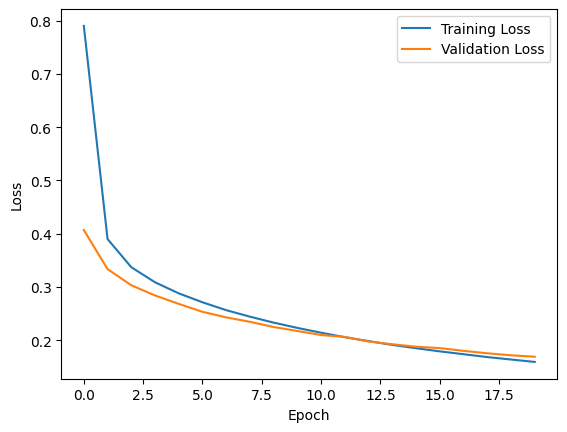

In [8]:
# Plot some training progress (e.g. plot the loss)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_testset, y_testset, verbose=0)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.1652, Test Accuracy: 0.9530


In [10]:
# Make predictions on the test set
predictions = model.predict(x_testset)

313/313 [==============================] - 1s 1ms/step


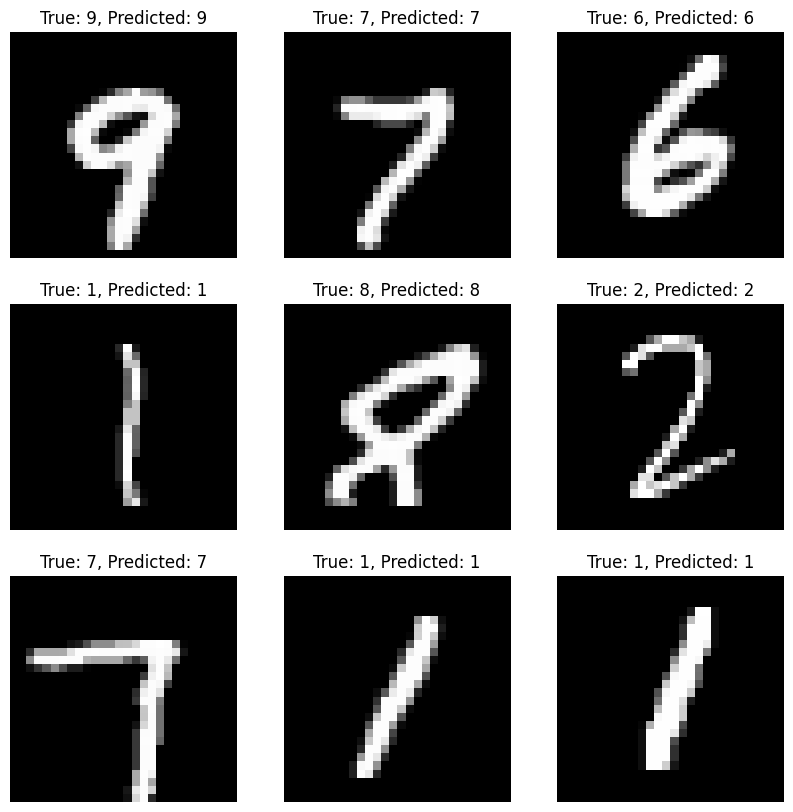

In [15]:
# Visualize some random predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    idx = np.random.randint(0, len(x_testset))
    plt.imshow(x_testset[idx].numpy().squeeze(), cmap='gray')
    plt.title(f"True: {y_testset[idx].numpy()}, Predicted: {np.argmax(predictions[idx])}")
    plt.axis('off')
plt.show()

**FINDINGS**
* Considering the visualisation of random images, the falsely predicted images appeaer to be more hard to identified for human eyes as well. For instance the predicted 9 is similar to a 7.

#### Step 6: Hyperparameter Finetuning

In [12]:
 # Have a brief (!) experiment with different settings for the hyperparameters: batch_size, learning_rate, hidden_layer_sizes.

model2 = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='relu'),    # Added hidden layer with 128 neurons
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

model2.compile(optimizer=SGD(0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

history2 = model2.fit(x_trainset, y_trainset, batch_size=32, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.7248 - accuracy: 0.8053 - val_loss: 0.3430 - val_accuracy: 0.9032
Epoch 2/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3252 - accuracy: 0.9067 - val_loss: 0.2780 - val_accuracy: 0.9187
Epoch 3/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2733 - accuracy: 0.9217 - val_loss: 0.2453 - val_accuracy: 0.9285
Epoch 4/50
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2393 - accuracy: 0.9313 - val_loss: 0.2166 - val_accuracy: 0.9372
Epoch 5/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2123 - accuracy: 0.9387 - val_loss: 0.1994 - val_accuracy: 0.9425
Epoch 6/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1900 - accuracy: 0.9449 - val_loss: 0.1823 - val_accuracy: 0.9472
Epoch 7/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1719 - accuracy: 0.9501 - val_loss: 0.1671 - val_accuracy:

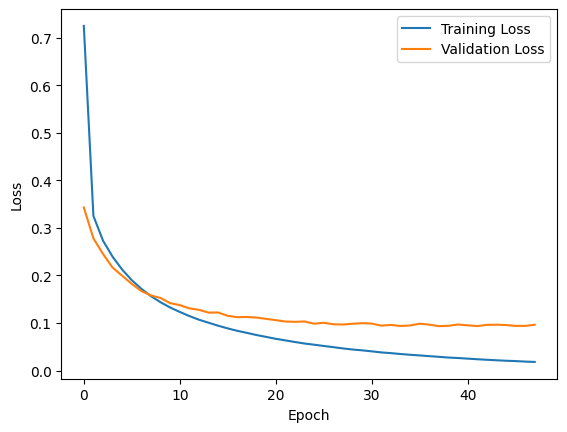

In [13]:
# Plot some training progress (e.g. plot the loss)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Evaluate the model on the test set
test_loss2, test_accuracy2 = model2.evaluate(x_testset, y_testset, verbose=0)
print(f'Test Loss: {test_loss2:.4f}, Test Accuracy: {test_accuracy2:.4f}')

Test Loss: 0.0880, Test Accuracy: 0.9734
